# AWS-ASDI
EDA on the NOAA Global Historical Climatology Network Daily Dataset. This dataset contains over 200 years worth of climate data, and we will analyze the dataset through the use of data science tools that are scalable (modin and NumS). Because the tools we use are scalable, we are able to run the same code on a laptop and cluster of nodes. Before getting started, make sure you set `num_cpus` in `ray_init()` to the number of physical cores on the CPU running this notebook for optimal performance, otherwise Ray might automatically set it to logical cores that include hyperthreading.

Confirm everything is installed through:
```sh
pip3 install -r requirements
```

In [1]:
import ray
ray.init(ignore_reinit_error=True, num_cpus=32, _temp_dir="/home/brian/external/aws-asdi/ray_temp");
import modin.pandas as pd
import pandas
from nums import numpy as nps
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os

2021-07-19 16:16:52,510	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


## Downloading the data and organization
https://registry.opendata.aws/noaa-ghcn/

Can use AWS CLI to speed things up by downloading it locally.

To view files:
```sh
aws s3 ls s3://noaa-ghcn-pds/ --no-sign-request
```

To download locally (*about 100GB of free data is needed on disk*):
To view files:
```sh
mkdir data
aws s3 cp --recursive s3://noaa-ghcn-pds/ --no-sign-request data
```

If downloading will take too much storage space, we can run this notebook completely off of memory, by setting the `local` tag to `False` in some function arguments.

File directory should look like this:
```
├── data/
├── figures/
├── eda.ipynb
├── README.md
└── requirements.txt
```

Documentation is here: https://docs.opendata.aws/noaa-ghcn-pds/readme.html

Here, we test downloading a `.csv` file directly from the AWS s3 bucket to memory.

In [2]:
%%time
### Getting started
climate_2020 = pd.read_csv('s3://noaa-ghcn-pds/csv/2020.csv', header=None)
climate_2020.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
climate_2020["YEAR/MONTH/DAY"] = pd.to_datetime(climate_2020["YEAR/MONTH/DAY"], format="%Y%m%d")

CPU times: user 10.5 s, sys: 2.78 s, total: 13.2 s
Wall time: 1min 13s


## Global Variables and DataFrames
Some variables and DataFrames that will be useful in parsing out data.

In [3]:
# Global variables
elements = ["PRCP", "SNOW", "SNWD", "TMAX", "TMIN"]
years = list(range(1763, 2022))

For stations, the data is formatted like this:
```
Variable	Columns	Type	Example
ID	1-11	Character	EI000003980
LATITUDE	13-20	Real	55.3717
LONGITUDE	22-30	Real	-7.3400
ELEVATION	32-37	Real	21.0
STATE	39-40	Character
NAME	42-71	Character	MALIN HEAD
GSN FLAG	73-75	Character	GSN
HCN/CRN FLAG	77-79	Character
WMO ID	81-85	Character	03980
```

A sample query:
```
AE000041196  25.3330   55.5170   34.0    SHARJAH INTER. AIRP            GSN     41196
```

In [4]:
stations = pd.read_fwf('s3://noaa-ghcn-pds/ghcnd-stations.txt', widths=[12, 9, 10, 7, 3, 31, 4, 4, 6], header=None)
stations.columns = ["ID", "LATITUDE", "LONGITUDE", "ELEVATION", "STATE", "NAME", "GSN FLAG", "HCN/CRN FLAG", "WMO ID"]
stations

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
0,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
1,ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
2,AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
3,AEM00041194,25.2550,55.3640,10.4,NaN,DUBAI INTL,NaN,NaN,41194.0
4,AEM00041217,24.4330,54.6510,26.8,NaN,ABU DHABI INTL,NaN,NaN,41217.0
...,...,...,...,...,...,...,...,...,...
118487,ZI000067969,-21.0500,29.3670,861.0,NaN,WEST NICHOLSON,NaN,NaN,67969.0
118488,ZI000067975,-20.0670,30.8670,1095.0,NaN,MASVINGO,NaN,NaN,67975.0
118489,ZI000067977,-21.0170,31.5830,430.0,NaN,BUFFALO RANGE,NaN,NaN,67977.0
118490,ZI000067983,-20.2000,32.6160,1132.0,NaN,CHIPINGE,GSN,NaN,67983.0


In [5]:
country_codes = pd.read_csv("s3://noaa-ghcn-pds/ghcnd-countries.txt", delimiter="\n", header=None)[0].str.extract('(?P<code>.{2})(?P<country>.{0,})')
country_codes

To request implementation, send an email to feature_requests@modin.org.


,code,country
0,AC,Antigua and Barbuda
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AG,Algeria
4,AJ,Azerbaijan
...,...,...
214,WI,Western Sahara
215,WQ,Wake Island [United States]
216,WZ,Swaziland
217,ZA,Zambia


## Utility Functions
Some helpful functions in helping with EDA

In [6]:
def data_loader(year, local=False):
    if local:
        df = pd.read_csv('data/' + str(year) + '.csv', header=None)
    else:
        df = pd.read_csv('s3://noaa-ghcn-pds/csv/' + str(year) + '.csv', header=None)
    df.columns = ["ID", "YEAR/MONTH/DAY", "ELEMENT", "DATA VALUE", "M-FLAG", "Q-FLAG", "S-FLAG", "OBS-TIME"]
    df["YEAR/MONTH/DAY"] = pd.to_datetime(df["YEAR/MONTH/DAY"], format="%Y%m%d")
    return df

In [7]:
def df_filter(df, _id, element):
    return df.loc[(df["ID"] == _id) & (df["ELEMENT"] == element)][["YEAR/MONTH/DAY", "DATA VALUE"]].set_index("YEAR/MONTH/DAY")

In [244]:
#same as df_filter, but a vector of ALL the data
def df_filter_vector(_id, element, local=False):
    df_vector = pd.DataFrame(columns=["DATA VALUE"])
    for year in tqdm(years):
        if local:
            df = df_filter(dfs[year], _id, element)
        else:
            df = df_filter(data_loader(year), _id, element)
            
        if df_vector.empty:
            df_vector = df
        else:
            df_vector = df_vector.append(df)
    return df_vector

In [8]:
#print statements are replaced with tqdm functions
# MatPlotLib runs on single thread, we can parallelize plotting by using Ray
@ray.remote
def plotter(df, _id, element, save=False, year=None):
    station_name = stations.loc[stations['ID'] == _id]["NAME"].item()
    df = df_filter(df, _id, element)
    
    if df.empty:
        tqdm.write(element + " data on " + str(year) + " for " + station_name + " with id: " + _id + " is empty. Plotting is skipped.")
        return

    plt.figure(figsize=(20, 10))
    plt.plot(df)
    plt.title(element + " Data at " + station_name)
    plt.xlabel("Date")
    plt.ylabel("Value")
    #plt.xlim() #figure out a way to set limit of year
    plt.ylim(-100, 400)
    if save:
        directory = "figures/" + _id + "/" + element
        try:
            # Create target directory
            os.makedirs(directory)
            tqdm.write(f"Directory " + directory + " Created ")
        except FileExistsError:
            tqdm.write(f"Directory " + directory + " already exists. File " + directory + "/" + str(year) + ".png has been saved successfully.")
        
        plt.savefig(directory + "/" + str(year) + ".png")
    plt.clf()

We can also store all the dataframes into memory, given that there is enough RAM. Dataset is ~100GB, so something more that that should be fine. (Uses 190GB of memory on this system)

In [9]:
dfs = {}
for year in tqdm(years):
    dfs[year] = data_loader(year, local=True) 

  0%|          | 0/259 [00:00<?, ?it/s]

In [84]:
dfs[years[0]].groupby(dfs[years[0]]["ID"].str.slice(stop=2))["DATA VALUE"].sum()

ID
AE     519865
AF      67168
AG    3365075
AJ     575644
AL      27366
       ...   
WF     288938
WI      69554
WQ     110031
ZA       1083
ZI      26033
Name: DATA VALUE, Length: 194, dtype: int64

In [87]:
station_data_freq = pd.DataFrame()
years.reverse() #reverse, so NaNs can be filled in to missing/old data

for year in tqdm(years):
    station_data_freq[year] = dfs[year].groupby(dfs[year]["ID"].str.slice(stop=2))["DATA VALUE"].sum()

years.reverse()
station_data_freq = station_data_freq.fillna(0)

  0%|          | 0/259 [00:00<?, ?it/s]

In [130]:
station_data_freq.T
    

ID,AE,AF,AG,AJ,AL,AM,AO,AQ,AR,AS,...,UZ,VE,VM,VQ,WA,WF,WI,WQ,ZA,ZI
2021,519865.0,67168.0,3365075.0,575644.0,27366.0,528187.0,116387.0,233685.0,5736600.0,65259175.0,...,1665843.0,308660.0,1594501.0,1012654.0,777103.0,288938.0,69554.0,110031.0,1083.0,26033.0
2020,1049427.0,347809.0,6468526.0,1117900.0,149494.0,1063089.0,296152.0,620414.0,10303967.0,121229268.0,...,2944183.0,1060313.0,2830827.0,2002028.0,1310837.0,452695.0,149346.0,95449.0,7404.0,79597.0
2019,965715.0,381186.0,6352635.0,1155516.0,162282.0,1099505.0,264390.0,465857.0,8858792.0,112609962.0,...,3108996.0,540122.0,3350807.0,1938332.0,1793524.0,615150.0,135084.0,189020.0,28963.0,140548.0
2018,888756.0,274279.0,6694154.0,1174363.0,164416.0,1132851.0,208387.0,441797.0,8897612.0,120038907.0,...,2955479.0,1282236.0,2793026.0,1756558.0,1356098.0,476696.0,110540.0,98106.0,15406.0,210488.0
2017,910630.0,209730.0,6374097.0,924363.0,154446.0,998756.0,249585.0,437014.0,9310667.0,124485288.0,...,3090817.0,509367.0,2642634.0,1758009.0,1544604.0,535018.0,72900.0,122131.0,19058.0,387086.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
for index, row in tqdm(country_codes.iterrows()): 
    if row[0] in station_data_freq.T.columns:
        fig = plt.figure(figsize=(10, 10))
        ax = station_data_freq.T[row[0]].plot()
        ax.set_xlabel("Years")
        ax.set_ylabel("Number of Data Points")
        #filename = 
        plt.savefig(("figures/datasamples/" + row[1] + ".png").replace(" ", "_"))
        plt.clf()

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [133]:
sample_points = []
for year in tqdm(years):
    sample_points.append(len(dfs[year].index))
    

  0%|          | 0/259 [00:00<?, ?it/s]

Note that there is a dip at the end. That is due to this dataset being live and including the year 2021 (the current year making this notebook).

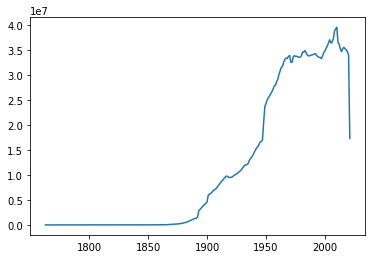

In [134]:
plt.plot(years, sample_points)

In [ ]:
"""
for _id in tqdm(stations["ID"]):
    for element in elements:
        for year in years:
            plotter.remote(dfs[year], _id, element, save=True, year=year)
"""

In [245]:
time_series = df_filter_vector("CA006158350", "PRCP", local=True)
time_series

  0%|          | 0/259 [00:00<?, ?it/s]

,DATA VALUE
YEAR/MONTH/DAY,
1840-05-01,64
1840-05-02,0
1840-05-03,99
1840-05-04,127
1840-05-05,0
...,...
2017-04-24,50
2017-04-25,0
2017-04-26,0


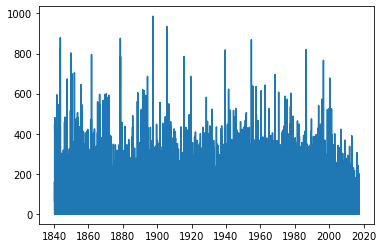

In [246]:
plt.plot(time_series)

## Modeling with NumS
### Linear Regression

In [144]:
from nums.experimental import nums_modin

def create_design_matrix(_id, element, years, convert_nps=True, local=False):
    df_design = pd.DataFrame(columns=pd.date_range(start="2020-01-01", end="2020-12-31").strftime('%m-%d'))
    station_name = stations.loc[stations['ID'] == _id]["NAME"].item()
    
    for year in tqdm(years):
        if local:
            df = dfs[year]
        else:
            try:
                df = data_loader(year)
            except ClientError:
                tqdm.write(str(year) + ".csv doesn't exist on remote, addition to design matrix is skipped.")
                continue
            
        df = df_filter(df, _id, element)
        if df.empty:
            tqdm.write(element + " data on " + str(year) + " for " + station_name + " with id: " + _id + " is empty. Addition to design matrix is skipped.")
            continue
        df.index = df.index.strftime('%m-%d')
        df.columns = [year]
        df = df.T
        df_design = df_design.append(df)


    df_design.index.name = None
    if convert_nps:
        #return nums_modin.from_modin(df_design.astype(int)) 
        """
        TODO: Bug? Fails at:
        ----> 1 nums_modin.from_modin(design_matrix.astype(np.int64))

        ~/external/nums/nums/experimental/nums_modin.py in from_modin(df)
             60         if type(frame.dtypes.dtype) == np.dtype:
             61             continue
        ---> 62         assert dt == frame.dtypes
             63     dtype = np.__getattribute__(str(dtype))
             64 

        AssertionError: 
        """
        return nps.array(df_design.to_numpy().astype(np.double))
    return df_design

In [145]:
#Test to see if design matrix works
design_matrix = create_design_matrix('EZE00100082', 'TMAX', years, local=True)

  0%|          | 0/259 [00:00<?, ?it/s]

TMAX data on 1763 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1764 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1765 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1766 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1767 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1768 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1769 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1770 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1771 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 1772 f

TMAX data on 2006 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2007 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2008 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2009 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2010 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2011 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2012 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2013 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2014 for PRAHA-KLEMENTINUM with id: EZE00100082 is empty. Addition to design matrix is skipped.
TMAX data on 2015 f

In [146]:
np.save("test.npy", design_matrix.get())

In [147]:
design_matrix = nps.array(np.load("test.npy"))

In [150]:
A = nps.nan_to_num(design_matrix)
y = nps.arange(1775, design_matrix.shape[0] + 1775, 1)

test modeling with sklearn

In [151]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model.fit(A.get(), y.get())
sklearn_coef = model.coef_

In [152]:
result1, result2, result3, result4 = np.linalg.lstsq(A.get(), y.get(), rcond=None)
result1.shape

(366,)

In [153]:
from nums.models.glms import LinearRegression

In [154]:
LinearRegression

nums.models.glms.LinearRegression

In [155]:
model = LinearRegression()
model.fit(A, y)

In [158]:
model._beta.get();

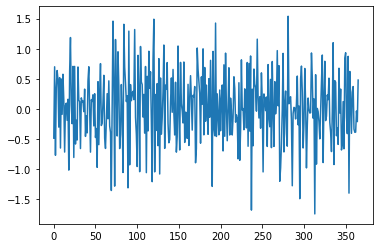

In [157]:
plt.plot(sklearn_coef)

In [ ]:
model.predict(design_matrix[0]).get()

In [ ]:
block_shape = design_matrix.T.block_shape
shape = design_matrix.T.shape
R_shape = (shape[1], shape[1])
R_block_shape = (block_shape[1], block_shape[1])

### Time series analysis

In [176]:
elements

['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']

In [183]:
df_filter(dfs[2000], "CA006158350", "PRCP")

,DATA VALUE
YEAR/MONTH/DAY,
2000-01-01,0
2000-01-02,18
2000-01-03,46
2000-01-04,0
2000-01-05,0
...,...
2000-12-27,0
2000-12-28,0
2000-12-29,38


In [190]:
elements

['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']

In [ ]:
def create_time_series_design_matrix(_id, element, features):
    df = pd.DataFrame(columns=features)
    for year in tqdm(years):
        

In [196]:
df = pd.DataFrame(columns=elements)
#for year in tqdm(years):
year = 2000
for feature in ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']:
    df[feature] = df_filter(dfs[year], "CA006158350", feature)

In [203]:
A = nps.array(df[['PRCP', 'TMAX', 'TMIN']].to_numpy())

In [204]:
y = nps.array(df['SNOW'].to_numpy())

In [205]:
from nums.models.glms import LogisticRegression

In [206]:
model = model.fit(A, y)

AttributeError: 'NoneType' object has no attribute 'fit'

In [ ]:
%%time
tmin = climate_2020[climate_2020["ELEMENT"] == "TMIN"]
tmax = climate_2020[climate_2020["ELEMENT"] == "TMAX"]

In [ ]:
precipication["DATA VALUE"].plot()

In [ ]:
snow = climate_2020[climate_2020["ELEMENT"] == "SNOW"]
snow_depth = climate_2020[climate_2020["ELEMENT"] == "SNWD"]

In [ ]:
snow["DATA VALUE"].plot()

In [ ]:
snow = climate_2020[climate_2020["ELEMENT"] == "SNOW"]

In [ ]:
climate_2020["country_code"] = climate_2020["ID"].str.slice(stop=2)

In [ ]:
climate_2020

In [ ]:
climate_2020[climate_2020["country_code"] == "US"]

In [ ]:
climate_2020[climate_2020["ID"] == "US10adam002"]

In [ ]:
climate_2020[climate_2020["ID"] == "US10adam002"].plot(x = "YEAR/MONTH/DAY", y="DATA VALUE")
climate_2020[climate_2020["ID"] == "USW00096408"].plot(x = "YEAR/MONTH/DAY", y="DATA VALUE")
climate_2020[climate_2020["ID"] == "US10adam002"].plot(x = "YEAR/MONTH/DAY", y="DATA VALUE")

When done, run this so you can properly shutdown Ray

In [247]:
ray.shutdown()